# EDA (Exploratory Data Analysis)

In this notebook, we will explore the House dataset found on Kaggle (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). The task was to find predictors for the response variable (SalePrice) such that it can be used for regression on unseen data, with explanatory variables such as GarageArea, SaleCondition, LotArea, Neighborhood (location), OverallQual(ity). This book deals predominantly with explaratory analysis. We have another book in this folder which presents regression results.

Note, whilst we have plotted the graphs inline, they are quite unsatisfactory. Therefore we advice changing the plots to be window-based allowing full-screening and zooming in. To do this, in the import section below, change '**%matplotlib notebook'** to '**%matplotlib tk'**', and you will probably need to restart the kernel aswell.

## Preliminaries (imports and function definitions)

The neccessary packages are below (however the regresion_plots package is self-written and requires atleast the statsmodels package), and the functions defined are pretty self-explanatory, however the 'transform_house_pd' function is explained later.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn.decomposition import PCA
from regression_plots import create_regression_plots, create_partial_plots, \
    create_partial_residual_plots

%matplotlib notebook

In [2]:
def price_data_preparation(datafile):

    df = pd.read_csv(datafile)
    
    df = df.drop(columns=['Id'])
    
    df = df.fillna(value=0)

    return df

In [3]:
def transform_house_pd(df: pd.DataFrame):
    ## step: transforms and normalization

    # step: power transforms
    # warn: constants should be added to each variable below if zero values are encountered, or to make them positive.

    # continuous transforms
    df['SalePrice'] = np.log(df['SalePrice'])
    df['GrLivArea'] = (np.log(df['GrLivArea']))
    df['GarageArea'] = np.power(df['GarageArea'], 0.8)
    df['TotalBsmtSF'] = np.power(df['TotalBsmtSF'], 0.41)
    df['1stFlrSF'] = np.power(df['1stFlrSF'], -0.1)
    df['MasVnrArea'] = np.power(df['MasVnrArea'], 0.25)

    # ordinal transforms
    df['OverallQual'] = np.power(df['OverallQual'], 1.35)
    df['GarageCars'] = np.power(df['GarageCars'], 0.8)
    df['TotRmsAbvGrd'] = np.power(df['TotRmsAbvGrd'], 0.375)

    return df

# Regression Diagnostics

In [4]:
df = price_data_preparation('train.csv')

We study first the R^2 matrix. Note that the computing of the correlation matrix (and thus the R^2 matrix) below automatically selects quantative variables and discards qualitative ones. Hence at this point in time we do not study qualitative (nominal) variables.

In [5]:
corr_matrix = df.corr()
R_squared = np.multiply(corr_matrix, corr_matrix)

## Plot R^2 graph, assuming R^2 (> 0.3) signifies an existing correlation

We can visualise correlation clusters via a graph, similar to a taxonomic map. For example, see [Graphical Techniques for Multivariate Data by Brian Everitt (1975)]. Additionally, the book presents a visual approach similar to heatmaps called SHADE, which also cluster correlations.

In [6]:
corr_graph_vals = R_squared[R_squared > 0.3].fillna(0)
corr_graph_vals = corr_graph_vals.round(3)

<IPython.core.display.Javascript object>


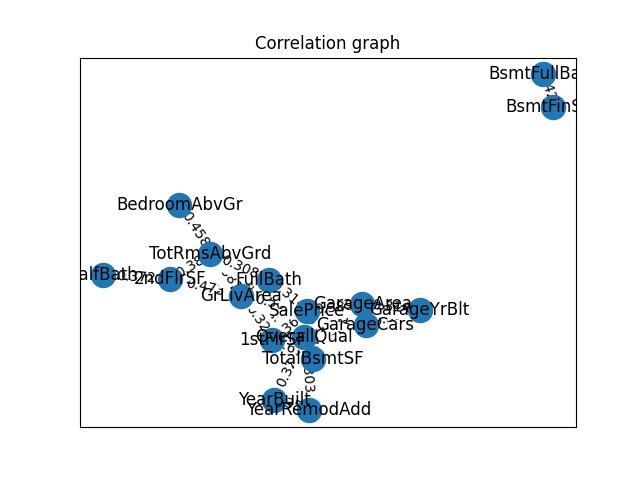

In [7]:
# remove diagonal entries, and remove variables with no strong correlation whatsoever (those set to zero above)
cols = corr_graph_vals.columns
for c in cols: corr_graph_vals[c][c] = 0
var_mask = (corr_graph_vals.T != 0).any()
corr_graph_vals = corr_graph_vals[var_mask]
corr_graph_vals = corr_graph_vals.T[var_mask].T
corr_graph = nx.from_pandas_adjacency(corr_graph_vals)

fig, ax = plt.subplots(1)

ax.set_title("Correlation graph")
pos = nx.spring_layout(corr_graph)
_ = nx.draw_networkx(corr_graph,pos,ax=ax)
weights = nx.get_edge_attributes(corr_graph, 'weight')
_ = nx.draw_networkx_edge_labels(corr_graph,pos,ax=ax,edge_labels=weights)

If plotting via '%matplotlib tk', we can zoom in and look at the correlations more closely. We find that the most correlated continuous/discrete variables to SalePrice are OverallQual, and GrLiveArea.

## Print R^2 matrix sorted by SalePrice

In [8]:
pd.set_option('display.max_rows', len(R_squared))
R_squared_sorted = R_squared.sort_values(by=['SalePrice'], ascending='True')
R_squared_sorted['SalePrice']

BsmtFinSF2       0.000129
BsmtHalfBath     0.000284
MiscVal          0.000449
LowQualFinSF     0.000656
YrSold           0.000837
3SsnPorch        0.001988
MoSold           0.002156
OverallCond      0.006062
MSSubClass       0.007104
PoolArea         0.008538
ScreenPorch      0.012420
EnclosedPorch    0.016532
KitchenAbvGr     0.018471
BedroomAbvGr     0.028296
LotFrontage      0.043942
BsmtUnfSF        0.046001
BsmtFullBath     0.051585
GarageYrBlt      0.068312
LotArea          0.069613
HalfBath         0.080717
OpenPorchSF      0.099765
2ndFlrSF         0.101974
WoodDeckSF       0.105244
BsmtFinSF1       0.149320
Fireplaces       0.218023
MasVnrArea       0.223364
YearRemodAdd     0.257151
YearBuilt        0.273422
TotRmsAbvGrd     0.284860
FullBath         0.314344
1stFlrSF         0.367057
TotalBsmtSF      0.376481
GarageArea       0.388667
GarageCars       0.410124
GrLivArea        0.502149
OverallQual      0.625652
SalePrice        1.000000
Name: SalePrice, dtype: float64

## Choosing explanatory variables (Xs) for SalePrice (Y)


Let us choose the variables of multiple regression based on their R^2 sizes (see above). We select both 'primary vars' - those most correlated with SalePrice, and 'secondary vars'.  

In [9]:
primary_vars = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea']
secondary_vars = ['SalePrice', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', ]
comb_vars = np.append(primary_vars, secondary_vars[1:])

 ## Regression scatterplots
  

We present first the bivariate scatterplots between each variables of the primary vars, and then of the secondary vars. In the k-dimensional diagram below, the off-diagonals are the scatterplots, with the dashed black line representing the linear regression line, whilst the grey line represents the lowess line.

The diagonals represent the variables cumulative distribution functions (in blue) whilst the normal distribution (with zero mean and 1 sd) is plotted in orange as a frame of reference for symmetry. We choose this as it is easy to estimate and to determine skew by eye.

Note unfortunately that lowess does not always work, hence the errors printed below. Plotwise, sometimes we do not see the lowess plot on the diagrams below.  

<IPython.core.display.Javascript object>


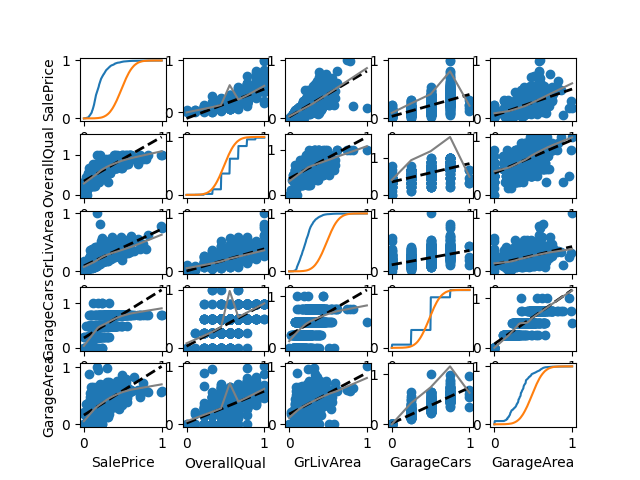

/home/irfan/.local/lib/python3.8/site-packages/statsmodels/nonparametric/smoothers_lowess.py:214: RuntimeWarning: invalid value encountered in greater_equal
  res, _ = _lowess(y, x, x, np.ones_like(x),


<IPython.core.display.Javascript object>


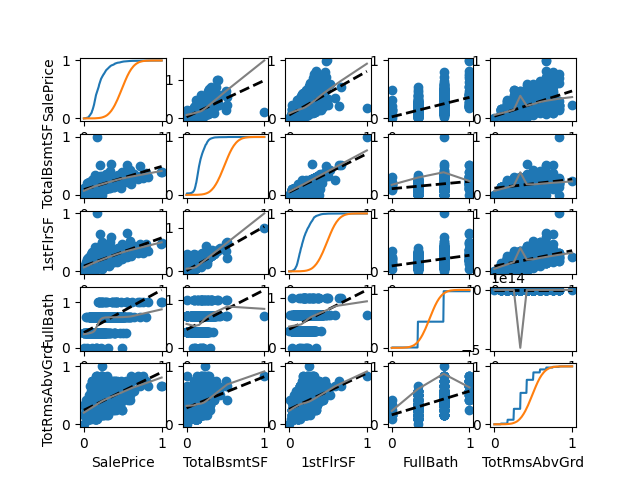

/home/irfan/.local/lib/python3.8/site-packages/statsmodels/nonparametric/smoothers_lowess.py:214: RuntimeWarning: invalid value encountered in greater_equal
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/irfan/.local/lib/python3.8/site-packages/statsmodels/nonparametric/smoothers_lowess.py:214: RuntimeWarning: invalid value encountered in greater_equal
  res, _ = _lowess(y, x, x, np.ones_like(x),


In [10]:
create_regression_plots(df[primary_vars], cols=None, use_cdf=True, hide_legend=True)
create_regression_plots(df[secondary_vars], cols=None, use_cdf=True, hide_legend=True)
plt.show()

## Transform variables to reduce skewness


From the cdf plots, we find that many of the variables are positively skewed. By trial and error we correct the skewness of the variables above by using the power transforms. The specific transforms are found within the transform_house_pd function above.

In [11]:
old_df = df.copy()
df = transform_house_pd(df)

We plot again the regression scatterplots, and notice how the variables cdfs (in blue) are more closely aligned with the orange symmetry cdf of the normal distribution. 

**Note, in the plot below and subsequent plots we do not rename our variables to reflect the transforms applied to them, for example we do not write Log(SalePrice), but rather just SalePrice.** The transforms however are all above (in the *transform_house_pd* function definition) for reference. All remaining plots uses the transformed variables.

<IPython.core.display.Javascript object>


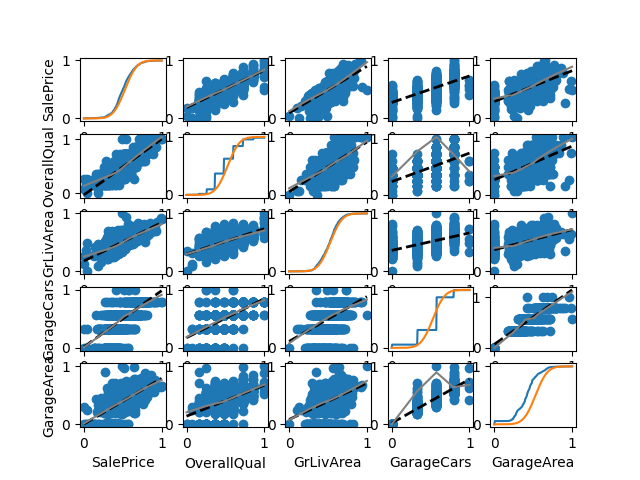

/home/irfan/.local/lib/python3.8/site-packages/statsmodels/nonparametric/smoothers_lowess.py:214: RuntimeWarning: invalid value encountered in greater_equal
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/irfan/.local/lib/python3.8/site-packages/statsmodels/nonparametric/smoothers_lowess.py:214: RuntimeWarning: invalid value encountered in greater_equal
  res, _ = _lowess(y, x, x, np.ones_like(x),


<IPython.core.display.Javascript object>


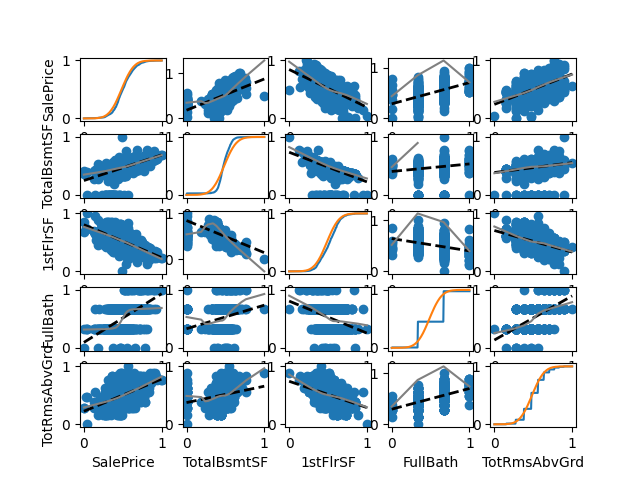

/home/irfan/.local/lib/python3.8/site-packages/statsmodels/nonparametric/smoothers_lowess.py:214: RuntimeWarning: invalid value encountered in greater_equal
  res, _ = _lowess(y, x, x, np.ones_like(x),


In [12]:
# substep: replot regression scatterplots
create_regression_plots(df[primary_vars], cols=None, use_cdf=True, hide_legend=True)
create_regression_plots(df[secondary_vars], cols=None, use_cdf=True, hide_legend=True)

 ## Component-residual plots


We can use comp-res plots to determine if non-linearity exists within our variables.

<IPython.core.display.Javascript object>


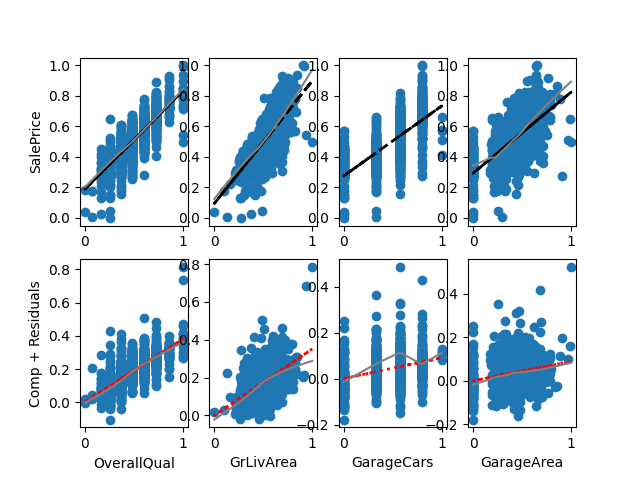

/home/irfan/.local/lib/python3.8/site-packages/statsmodels/nonparametric/smoothers_lowess.py:214: RuntimeWarning: invalid value encountered in greater_equal
  res, _ = _lowess(y, x, x, np.ones_like(x),


<IPython.core.display.Javascript object>


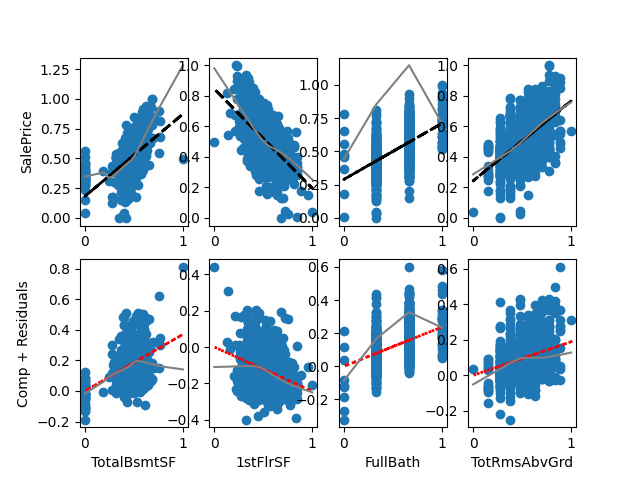

In [13]:
create_partial_residual_plots(df[primary_vars], 'SalePrice')
create_partial_residual_plots(df[secondary_vars], 'SalePrice')

From the primary variables: OverallQual and GarageArea are fine (linear). GrLivArea and GarageCars are slightly non-linear and non-monotonic.

From the secondary variables: All variables appear to be non-linear and non-monotonic.

## Partial regression plots (or added variable plots)

We now study the partial-regression plots to see find outliers if possible. The first row of plots below is the original partial-regression plot, with the potential outliers highlited in pink. Each scatterplot also has a kernel density estimate overlayed, and a regression line in dash-black, and a legend indicating the coefficent of the slope.

The second row of plots is the partial-regression plot of a dataset with the outliers of the first removed.

The outliers were selected based on the value of the pdf of the kernel density estimate, if the value was lower than 0.25 (the threshold variable below), then we selected it as a potential outlier. Other ways of indicating outliers is possible, via case deletion diagnostics. See for example the book: [Regression Diagnostics: An introduction by John Fox (2020)].

<IPython.core.display.Javascript object>


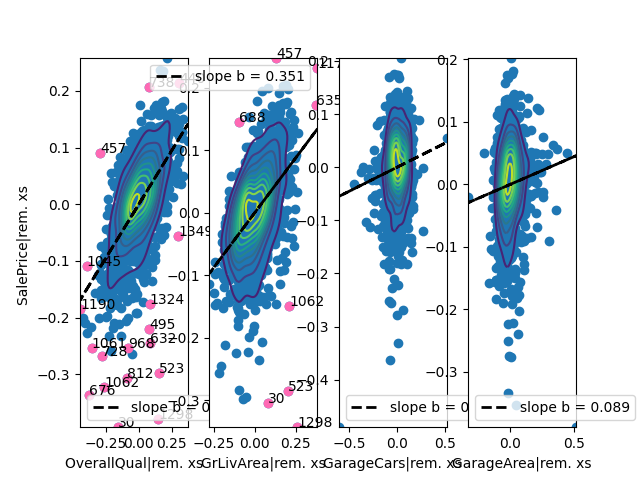

outliers: [30, 440, 457, 495, 523, 632, 635, 676, 688, 728, 738, 812, 968, 1045, 1061, 1062, 1173, 1190, 1298, 1324, 1349]


<IPython.core.display.Javascript object>


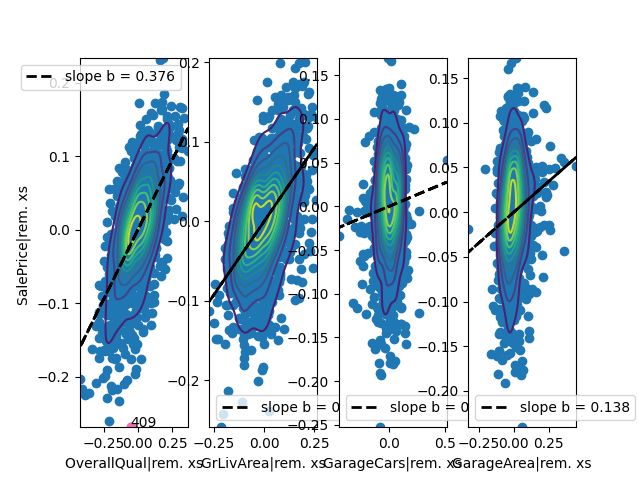

In [14]:
 threshold = 0.25
outlier_idxs = create_partial_plots(df[primary_vars], 'SalePrice', drop_rows=None, threshold=threshold)
print("outliers:", list(outlier_idxs))
_ = create_partial_plots(df[primary_vars], 'SalePrice', drop_rows=outlier_idxs, threshold=threshold)
plt.show()

# Clustering

With the outliers above, let us see if they conform to an existing grouping within our dataset. One way to do this is by applying PCA to the dataset and seeing if the first two components are sufficient to explain the majority of the variance. We can then study the plot of these first two components for clusters.

In [15]:
pca = PCA()
pca.fit(df[comb_vars].drop(columns=['SalePrice']))
pca.explained_variance_ratio_

array([9.92600003e-01, 4.99789588e-03, 2.27430681e-03, 8.37556291e-05,
       2.16242779e-05, 1.95024306e-05, 2.86757604e-06, 4.40281904e-08])

Since the first two components are 'large enough', let us see if there are any clusters in our dataset by plotting them.

 ## 2D projection

<IPython.core.display.Javascript object>


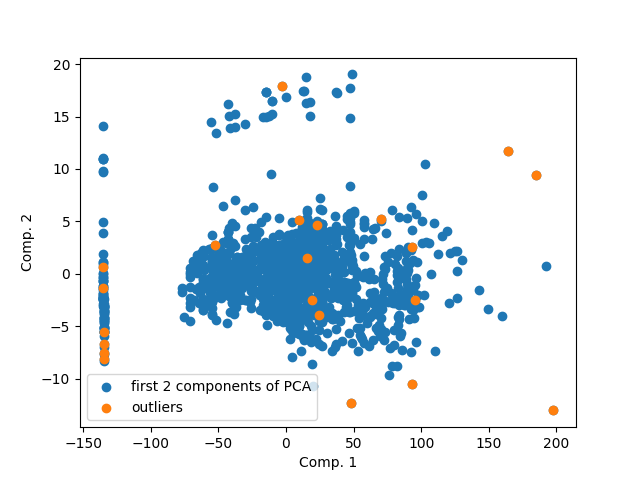

In [22]:
orig_trans_Xs = pca.fit_transform(df[comb_vars].drop(columns=['SalePrice']))
trans_Xs = orig_trans_Xs[:, :2]

fig, ax = plt.subplots(1)

ax.scatter(trans_Xs[:, 0], trans_Xs[:, 1], label='first 2 components of PCA')
ax.scatter(trans_Xs[outlier_idxs, 0], trans_Xs[outlier_idxs, 1], label='outliers')
ax.set_xlabel('Comp. 1')
ax.set_ylabel('Comp. 2')
plt.legend()
plt.show()

Interestingly, we find 3 clusters, 1) [Comp1 < -100,:], 2) [ -100 < Comp1 < 75, Comp2 > 12], 3) [Rest]. Some outliers are outliers even in the projected space, but most are not. However, We can plot these projections with respect to the response variable (SalePrice) to see if there is a further explanation.

## 3D projection

<IPython.core.display.Javascript object>


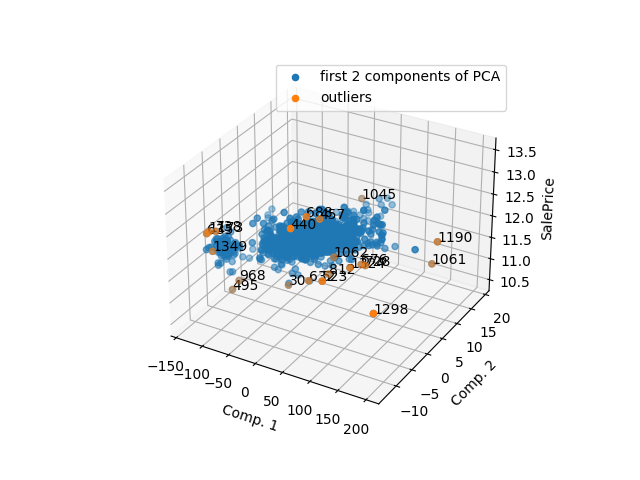

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(trans_Xs[:, 0], trans_Xs[:, 1], df['SalePrice'], label='first 2 components of PCA')
ax.scatter(trans_Xs[outlier_idxs, 0], trans_Xs[outlier_idxs, 1], df['SalePrice'][outlier_idxs], label='outliers')
for j in outlier_idxs:
    ax.text(trans_Xs[j, 0], trans_Xs[j, 1], df['SalePrice'][j], j)

ax.set_xlabel('Comp. 1')
ax.set_ylabel('Comp. 2')
ax.set_zlabel('SalePrice')

plt.legend()

We find that the major clusters are still present, but also that the majority of found outliers appear to be outliers even in this space. This is visible when rotating the plot above (possible if using '%matplotlib tk').

# Decision Tree classification

Let us see if these clusters above (the three clusters identified via PCA, and the outlier/non-outlier clusters), correspond to any meaningful relationship within the original dataset. 

Let us analyse the 3-cluster first:  1) [Comp1 < -100,:], 2) [ -100 < Comp1 < 75, Comp2 > 12], 3) [Rest].

<IPython.core.display.Javascript object>


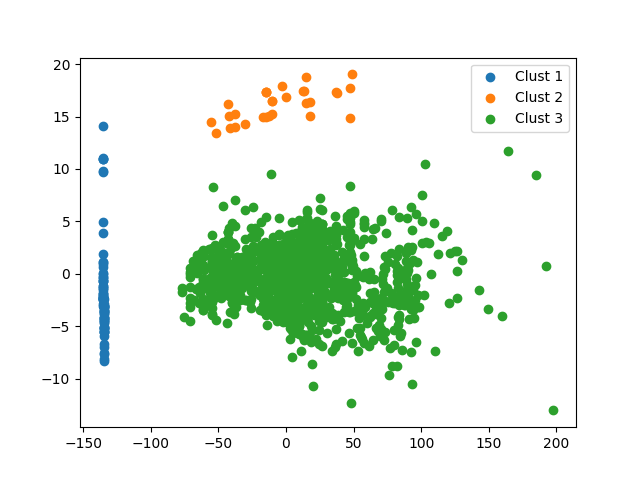

In [18]:
 clf = tree.DecisionTreeClassifier()
clust1_idx = np.flatnonzero(trans_Xs[:, 0] < -100)
clust2_idx = np.flatnonzero(((trans_Xs[:, 0] < 75) & (-100 < trans_Xs[:,0])) & (trans_Xs[:, 1] > 12))

num_samples = trans_Xs.shape[0]
clust3_idx = np.setdiff1d(np.arange(num_samples),np.append(clust1_idx,clust2_idx))

fig, ax = plt.subplots(1)

ax.scatter(trans_Xs[clust1_idx, 0], trans_Xs[clust1_idx, 1], label='Clust 1')
ax.scatter(trans_Xs[clust2_idx, 0], trans_Xs[clust2_idx, 1], label='Clust 2')
ax.scatter(trans_Xs[clust3_idx, 0], trans_Xs[clust3_idx, 1], label='Clust 3')
ax.legend()

In [19]:
# Create a new ordinal variable for the clusters: [0,1,2].
Y_class = np.empty(num_samples,dtype=int)
Y_class[clust1_idx] = 0
Y_class[clust2_idx] = 1
Y_class[clust3_idx] = 2

<IPython.core.display.Javascript object>


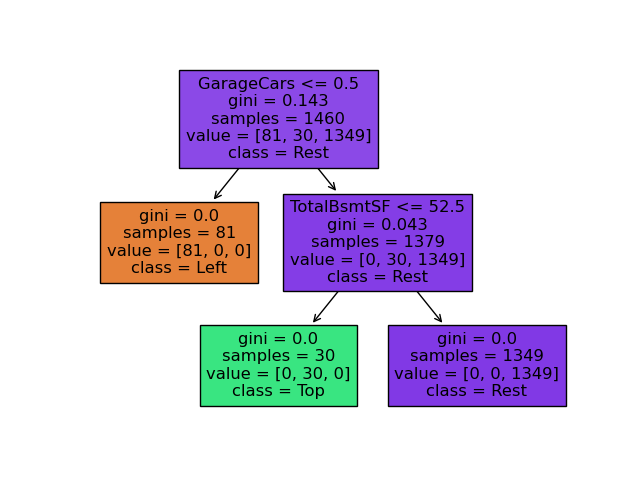

In [20]:
Xs_comb = old_df[comb_vars].drop(columns='SalePrice')
clf = clf.fit(Xs_comb.to_numpy(),Y_class)

fig,ax = plt.subplots(1)

_ = tree.plot_tree(clf,feature_names=Xs_comb.columns,class_names=['Left','Top','Rest'],
                   filled=True,proportion=False,ax=ax)

We find that the clusters can be identified well via two variables: GarageCars or TotalBsmtSF. It may be useful to  divide our dataset into three (based on these clusters above), then seeing if performing a regression for cluster bring benefits. However, we may be required to perform the regression diagnostics once more. Thus, if our goal is prediction (as oppose to EDA), starting with PCA might be easier.

Let us also see if the outliers have a specific pattern relative to non-outlying points. We already have the indices of the outliers, let us create a new dichotomous variable classifying between outliers and non-outliers [0,1]

<IPython.core.display.Javascript object>


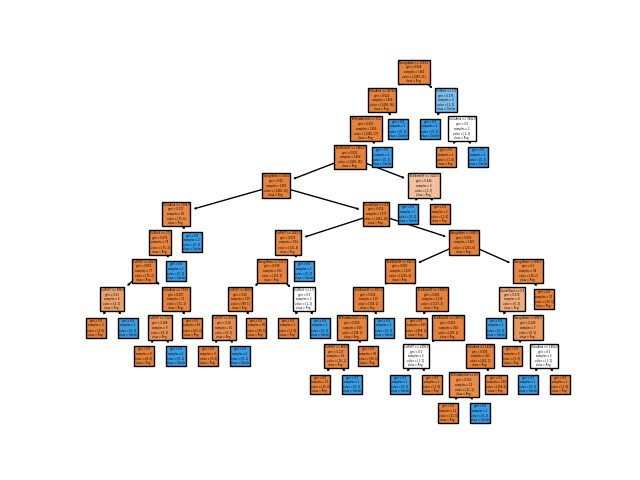

In [21]:
Y_out = np.zeros(num_samples,dtype=int)
Y_out[outlier_idxs] = 1

clf = clf.fit(Xs_comb.to_numpy(),Y_out)

fig,ax = plt.subplots(1)
_ = tree.plot_tree(clf,feature_names=Xs_comb.columns,class_names=['Reg.','Outlier'],
                   filled=True,proportion=False,ax=ax)


Looking at the tree, the DT was not able to find a simple explanation for the outliers.

Note that sklearn's plotting of trees does not allowing scaling (zooming-in) without much more code written for it. However, the plot above is sufficient to show that there isn't a clean partition of the dataset to determine outliers.  

# Summary & future work

In conclusion, we find that there are correlated variables that can be used as predictors for the house price. Some of these could be linearized quite well, others require further transforms. We found three clusters in the dataset which partitions data by whether GarageCar (size of garage in car capacity) is zero or not (since the variable takes integer values only), and if the TotalBsmtSF (total square feet of basement area) is less than 52.5. 

The analysis above only took into consideration quantative variables - continuous and discrete lattices. From the author's notes on the dataset, it suggests using the Neighbourhood variable as a predictor for house prices. Neighbourhood however is a qualitative nominal variable. Therefore future work would attempt a thorough analysis of all the qualitative variables for their significance in prediction.
